In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


import vocModel.nntools as nt
import vocData as voc
import vocModel
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"

In [4]:
train_set = voc.VOCDetection_Yolo(dataset_root_dir,  image_set = 'train')
val_set = voc.VOCDetection_Yolo(dataset_root_dir, image_set = 'val')
print (len(train_set), len(val_set))


5717 5823


In [6]:
def plot(exp, fig, axes):
    axes.clear()
    axes.plot([exp.history[k]['loss'] for k in range(exp.epoch)],
                 label="traininng loss")

    axes.legend()
    plt.tight_layout()
    fig.canvas.draw()

In [5]:
net = vocModel.YoloNet(7, 2, 20, 5,0.5)
net = net.to(device)
lr = 1e-4
# adam = torch.optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
stats_manager = vocModel.DetectionStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, optimizer, stats_manager,batch_size=4,
                     output_dir="data/test4", perform_validation_during_training=False)

<IPython.core.display.Javascript object>


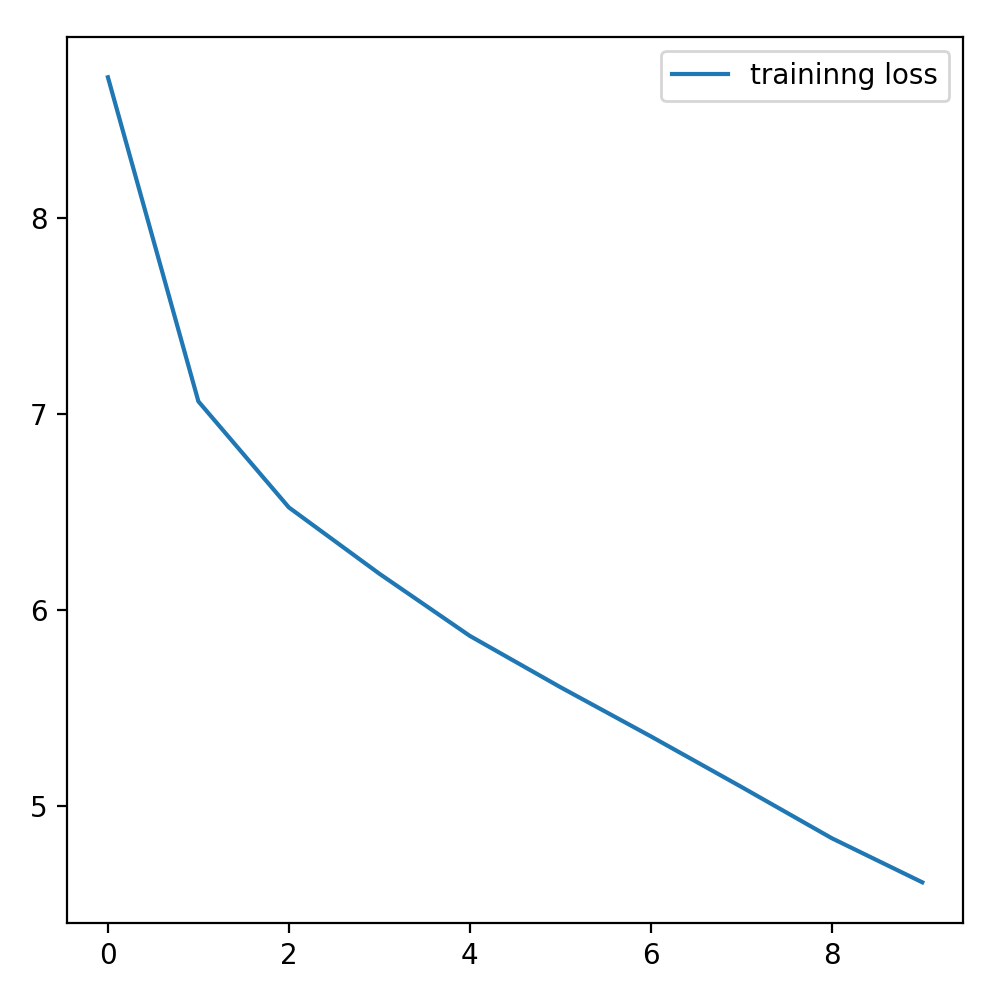

Start/Continue training from epoch 0
Epoch 1 loss :8.7193(Time: 446.78s)
Epoch 2 loss :7.0654(Time: 448.87s)
Epoch 3 loss :6.5243(Time: 450.16s)
Epoch 4 loss :6.1862(Time: 447.35s)
Epoch 5 loss :5.8688(Time: 448.45s)
Epoch 6 loss :5.6074(Time: 445.99s)
Epoch 7 loss :5.3563(Time: 446.25s)
Epoch 8 loss :5.0986(Time: 446.16s)
Epoch 9 loss :4.8365(Time: 447.41s)
Epoch 10 loss :4.6116(Time: 446.98s)
Finish training for 10 epochs


In [7]:
fig, axes = plt.subplots(ncols=1, figsize=(5, 5))
exp1.run(num_epochs=10, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [8]:
class_dict = {'person' :0, 'bird' : 1, 'cat' : 2, 'cow': 3, 'dog': 4, 'horse' : 5, 'sheep' : 6,
                  'aeroplane' :7, 'bicycle' :8, 'boat' :9, 'bus':10, 'car':11, 'motorbike' :12, 'train':13,
                  'bottle' :14, 'chair':15, 'diningtable':16, 'pottedplant':17, 'sofa': 18, 'tvmonitor':19}
class_list = list(class_dict)

color_list = ['b', 'g', 'c', 'm', 'y', 'k', 'w']

In [9]:
def image_transform(image, ax=plt):
    normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                 std=[1/0.229, 1/0.224, 1/0.225])    
    image = np.array(normalize(image).numpy())
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    return image

In [11]:
test_loader = DataLoader(val_set,batch_size=1,shuffle=False,num_workers=0)
test_iter = iter(test_loader)

In [24]:
C = 7
B = 2
w = 448
h = 448
img,(bboxes, labels, target)= next(test_iter)

img = img.to(device)

output = net.forward(img)

img = img.to('cpu')

output = output.to('cpu')
target = output[0]

print (target.shape)
# target = target[0]

cell_size = 1./C

fig, axs = plt.subplots(ncols=1, figsize=(5, 5))

white = (255,255,255)
light_blue = (255,200,100)
green = (0,255,0)
light_red = (30,30,255)

bboxes = bboxes[0]*448.0
labels = labels[0]
img_mod = image_transform(img[0])

for i in range(bboxes.size()[0]):
    xmin, ymin, xmax, ymax = bboxes[i][0].item(), bboxes[i][1].item(), bboxes[i][2].item(), bboxes[i][3].item()
    rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=4,edgecolor='r',facecolor='none')
    axs.add_patch(rect)

for i in range(7):
    for j in range(7):
        
        maxi = torch.max(target[i][j][4], target[i][j][9])
        max_idx = (target[i][j][9] > target[i][j][4]).item()
        t = torch.argmax(target[i][j][10:]).item()

#         print (maxi*target[i][j][10+t])
        if maxi > 0.1:
            w, h= target[i][j][2 + max_idx*5]**2, target[i][j][3 + max_idx*5]**2
            x_c, y_c =  target[i][j][max_idx*5], target[i][j][1 + max_idx*5]
            xmin = cell_size * (j + x_c) - w/2
            ymin = cell_size * (i + y_c) - h/2
            
            xmax = xmin + w
            ymax = ymin + h
            
            xmin, ymin, xmax, ymax = xmin.item()*448.0, ymin.item()*448.0\
            , xmax.item()*448.0, ymax.item()*448.0
            print (xmin, ymin, xmax, ymax, class_list[t], target[i][j][10+t],maxi)
            color = color_list[t % len(color_list)]
            rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=2,edgecolor=color,facecolor='none')
            axs.add_patch(rect)

axs.axis('off')
axs.imshow(img_mod)

torch.Size([7, 7, 30])


<IPython.core.display.Javascript object>

285.9003219604492 230.29165267944336 291.88937759399414 242.61140060424805 person tensor(0.1023, grad_fn=<SelectBackward>) tensor(0.1346, grad_fn=<MaxBackward2>)
150.19812393188477 268.7865791320801 316.72564697265625 324.3345527648926 chair tensor(0.1380, grad_fn=<SelectBackward>) tensor(0.1121, grad_fn=<MaxBackward2>)
249.84478378295898 286.5246887207031 274.7998809814453 324.96393966674805 chair tensor(0.4110, grad_fn=<SelectBackward>) tensor(0.1649, grad_fn=<MaxBackward2>)
67.26288795471191 263.9007797241211 386.02213287353516 400.3798713684082 diningtable tensor(0.1112, grad_fn=<SelectBackward>) tensor(0.2018, grad_fn=<MaxBackward2>)
278.8468894958496 304.69714736938477 321.9236831665039 375.5376739501953 chair tensor(0.3293, grad_fn=<SelectBackward>) tensor(0.2035, grad_fn=<MaxBackward2>)


In [ ]:
https://github.com/happyjin/pytorch-YOLO/blob/master/YoloLoss.py

In [ ]:
https://github.com/xiongzihua/pytorch-YOLO-v1

In [ ]:
https://github.com/Cartucho/mAP

In [ ]:
ttps://github.com/tjwhenderson/Multi-Object-Detection